Device: cpu
Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 

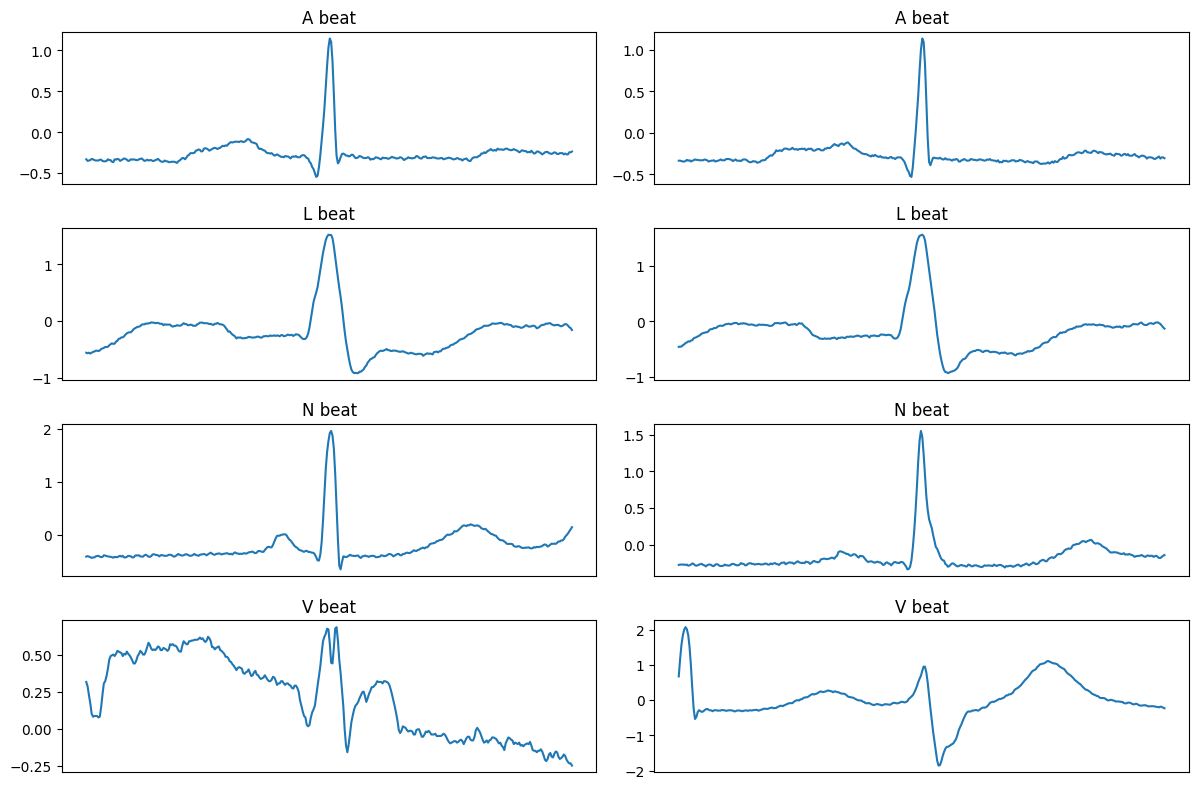

Applying bandpass filtering and per-beat standardization...
Label mapping: {np.str_('A'): 0, np.str_('L'): 1, np.str_('N'): 2, np.str_('V'): 3}
Class distribution (raw): Counter({np.int64(2): 12210, np.int64(1): 2490, np.int64(3): 682, np.int64(0): 42})
Train/Val/Test sizes: 10796 2314 2314
Train class counts: Counter({np.int64(2): 8546, np.int64(1): 1743, np.int64(3): 477, np.int64(0): 30})
Class weights: [359.86667     6.1939187   1.2632811  22.633123 ]
CNN_BiLSTM(
  (conv): Sequential(
    (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

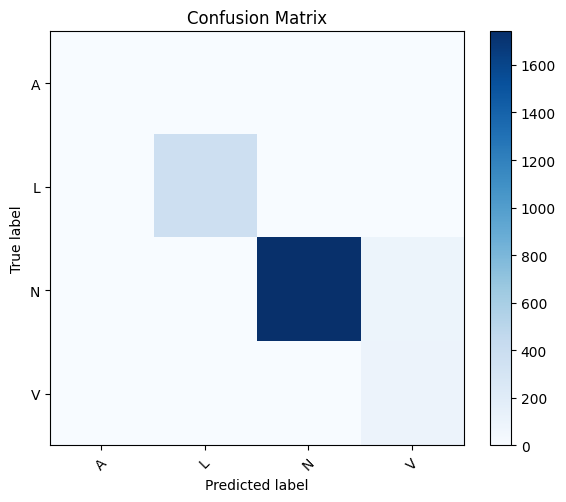

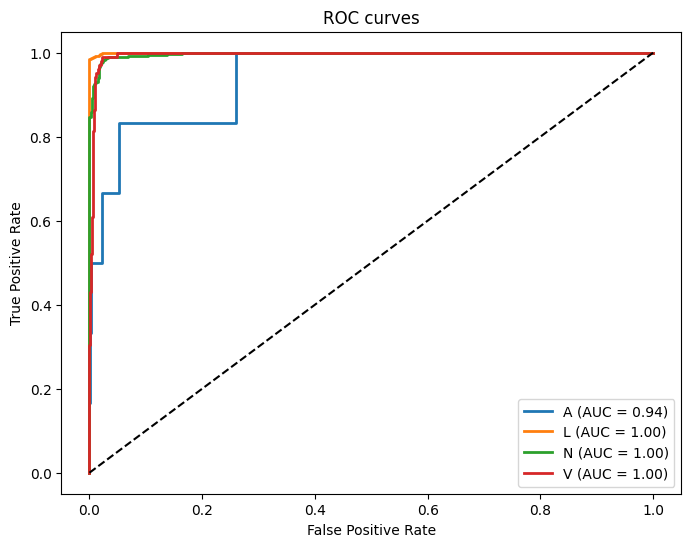

Done.


In [6]:
#!/usr/bin/env python3


import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import wfdb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from collections import Counter

import warnings
warnings.filterwarnings("ignore")


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)


PRE_SAMPLES = BEAT_WINDOW // 2
POST_SAMPLES = BEAT_WINDOW - PRE_SAMPLES



LABEL_MAP = {
    'N': 'N',
    'L': 'L',
    'R': 'R',  #ock beat
    'A': 'A',
    'V': 'V',
}
SELECTED_LABELS = set(LABEL_MAP.keys())



def bandpass_filter(signal, fs, lowcut=0.5, highcut=40.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, signal)
    return y

def read_record_signals(record_name, data_dir=DATA_DIR, channel=0):

    path = os.path.join(data_dir, record_name)
    record = wfdb.rdrecord(path)
    ann = wfdb.rdann(path, 'atr')
    # choose first available channel; MLII often channel 0
    sig = record.p_signal[:, channel]
    return sig, ann

def extract_beats_from_record(record_name):
    sig, ann = read_record_signals(record_name)
    for idx, sym in zip(ann.sample, ann.symbol):
        if sym in SELECTED_LABELS:
            start = idx - PRE_SAMPLES
            end = idx + POST_SAMPLES
            if start < 0 or end > len(sig):
                continue
            beat = sig[start:end]
            yield beat, LABEL_MAP[sym]


def build_dataset(record_list=RECORDS, max_records=None):
    all_beats = []
    all_labels = []
    used_records = record_list if max_records is None else record_list[:max_records]
    print("Loading records:", used_records[:min(10, len(used_records))], "...")
    for rec in used_records:
        try:
            for beat, label in extract_beats_from_record(rec):
                all_beats.append(beat)
                all_labels.append(label)
        except Exception as e:
            print(f"Skipping {rec} due to error: {e}")
    print("Total beats extracted:", len(all_beats))
    X = np.array(all_beats, dtype=np.float32)
    y = np.array(all_labels)
    return X, y


wfdb.dl_database('mitdb', dl_dir=DATA_DIR)

X_raw, y_raw = build_dataset(RECORDS, max_records=MAX_RECORDS)


def plot_sample_beats(X, y, classes, samples_per_class=2, save=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 2*len(classes)))
    for i, cls in enumerate(classes):
        cls_idx = np.where(y == cls)[0]
        if len(cls_idx) == 0:
            continue
        choose = np.random.choice(cls_idx, min(samples_per_class, len(cls_idx)), replace=False)
        for j, idx in enumerate(choose):
            plt.subplot(len(classes), samples_per_class, i*samples_per_class + j + 1)
            plt.plot(X[idx])
            plt.title(f"{cls} beat")
            plt.xticks([])
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=150)
    plt.show()

unique_labels = np.unique(y_raw)
print("Unique labels extracted:", unique_labels)
plot_sample_beats(X_raw, y_raw, unique_labels, samples_per_class=2)


print("Applying bandpass filtering and per-beat standardization...")
X_filt = np.array([bandpass_filter(x, FS, 0.5, 40.0) for x in X_raw], dtype=np.float32)
X_scaled = np.array([(x - np.mean(x)) / (np.std(x) + 1e-8) for x in X_filt], dtype=np.float32)


label_values = sorted(list(np.unique(y_raw)))
label_to_idx = {lab: i for i, lab in enumerate(label_values)}
idx_to_label = {i: lab for lab, i in label_to_idx.items()}
y_idx = np.array([label_to_idx[lab] for lab in y_raw], dtype=np.long)

print("Label mapping:", label_to_idx)
print("Class distribution (raw):", Counter(y_idx))

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_idx, test_size=0.30, stratify=y_idx, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED)
print("Train/Val/Test sizes:", len(X_train), len(X_val), len(X_test))

train_counts = Counter(y_train)
total = sum(train_counts.values())
class_weights = {cls: total/count for cls, count in train_counts.items()}
weights_array = np.array([class_weights[i] for i in range(len(label_to_idx))], dtype=np.float32)
print("Train class counts:", train_counts)
print("Class weights:", weights_array)


class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # shape: (channels, length) for Conv1d
        return torch.tensor(self.X[idx][None, :], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

train_ds = ECGDataset(X_train, y_train)
val_ds = ECGDataset(X_val, y_val)
test_ds = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


class CNN_BiLSTM(nn.Module):
    def __init__(self, in_channels=1, num_classes=5, hidden_size=128, lstm_layers=1, dropout=0.3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        dummy = torch.zeros(1, in_channels, BEAT_WINDOW)
        with torch.no_grad():
            out = self.conv(dummy)
            conv_out_len = out.shape[-1]
            conv_out_dim = out.shape[1]

        self.bilstm = nn.LSTM(input_size=conv_out_dim, hidden_size=hidden_size,
                              num_layers=lstm_layers, batch_first=True, bidirectional=True, dropout=dropout if lstm_layers>1 else 0)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(2*hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x: (B, 1, L)
        x = self.conv(x)                   # (B, C, L')
        x = x.permute(0, 2, 1)             # (B, L', C)
        out, _ = self.bilstm(x)            # (B, L', 2*H)
        out = out.mean(dim=1)              # (B, 2*H)
        logits = self.classifier(out)
        return logits


num_classes = len(label_to_idx)
model = CNN_BiLSTM(in_channels=1, num_classes=num_classes, hidden_size=128, lstm_layers=1, dropout=0.3).to(DEVICE)
print(model)


class_weights_tensor = torch.tensor(weights_array, dtype=torch.float32).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for Xb, yb in loader:
        Xb = Xb.to(DEVICE); yb = yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += Xb.size(0)
    return running_loss/total, correct/total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_probs = []
    all_true = []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(DEVICE); yb = yb.to(DEVICE)
            logits = model(Xb)
            loss = criterion(logits, yb)
            running_loss += loss.item() * Xb.size(0)
            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_true.append(yb.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)
    all_probs = np.concatenate(all_probs)
    acc = (all_preds == all_true).mean()
    return running_loss/len(all_true), acc, all_preds, all_probs, all_true


best_val_loss = np.inf
use_epochs = DEBUG_EPOCHS if DEBUG_EPOCHS > 0 else EPOCHS
print(f"Training for {use_epochs} epochs (debug_epochs set to {DEBUG_EPOCHS})")
for epoch in range(1, use_epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)
    print(f"Epoch {epoch}/{use_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_ecg_cnn_bilstm.pth")


model.load_state_dict(torch.load("best_ecg_cnn_bilstm.pth"))
test_loss, test_acc, test_preds, test_probs, test_true = evaluate(model, test_loader, criterion)
print("Final Test Loss:", test_loss, "Test Acc:", test_acc)
print("Classification Report:\n", classification_report(test_true, test_preds, target_names=[idx_to_label[i] for i in range(num_classes)]))

cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [idx_to_label[i] for i in range(num_classes)], rotation=45)
plt.yticks(tick_marks, [idx_to_label[i] for i in range(num_classes)])
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

from sklearn.preprocessing import label_binarize
y_bin = label_binarize(test_true, classes=list(range(num_classes)))
plt.figure(figsize=(8,6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{idx_to_label[i]} (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc='lower right')
plt.show()

print("Done.")

In [4]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 98.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


In [3]:
# Remove argparse and directly assign default values
DATA_DIR = './data/mitdb'
RECORDS = [
    '100','101','102','103','104','105','106','107','108','109',
    '111','112','113','114','115','116','117','118','119','121',
    '122','123','124','200','201','202','203','205','207','208','209',
    '210','212','213','214','215','217','219','220','221','222','223','228','230','231','232','233','234'
]
FS = 360
BEAT_WINDOW = 360
BATCH_SIZE = 64
EPOCHS = 50
LR = 1e-3
WEIGHT_DECAY = 1e-5
MAX_RECORDS = 10  # Corresponds to args.max_records
DEBUG_EPOCHS = 2  # Corresponds to args.debug_epochs